# **import libraries**

In [ ]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.spatial import distance

# **define path to yolov3 config , names , weights files**

In [ ]:
#path to yolo files
class_labels_path="/content/drive/MyDrive/Social Distancing Detector/YOLO_COCO/coco.names.txt"
weightsPath="/content/drive/MyDrive/Social Distancing Detector/YOLO_COCO/yolov3.weights"
configPath="/content/drive/MyDrive/Social Distancing Detector/YOLO_COCO/yolov3.cfg"

# **define thresholds :**

1.   **confidence_threshold** : minimum probability to filter weak detections
2.   **non_max_suppression_threshold** :threshold when applying non-maxima suppression
3.   **distance_treshold** : define distance treshold to filter closest detected person



In [ ]:
confidence_threshold=0.5
non_max_suppression_threshold=0.3
distance_threshold=70

# **load yolov3 function**

In [ ]:
def load_yolov3(configPath,weightsPath):
  # load our YOLO object detector trained on COCO dataset (80 classes) Load the YOLO network
  # # Give the configuration and weight files for the model and load the network
  print("loading YOLO from disk...")
  yolo_net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
  yolo_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
  # determine only the *output* layer names that we need from YOLO
  ln = yolo_net.getLayerNames()
  ln = [ln[i[0] - 1] for i in yolo_net.getUnconnectedOutLayers()]
  return(yolo_net,ln)

# **people detection**

In [ ]:
def detect_person(image,ln,yolo_net,confidence_threshold,non_max_suppression_threshold):
  # construct a blob from the input image :The input to the network is a so-called blob object
  # cv.dnn.blobFromImage(img, scale, size, mean) transforms the image into a blob
  #A blob is a 4D numpy array object (images, channels, width, height).
  (H, W) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
  # perform a forward pass of the YOLO object detector
  yolo_net.setInput(blob)
  layerOutputs = yolo_net.forward(ln)
  # initialize lists of detected bounding boxes, confidences, and class IDs
  # Our bounding boxes around the object
  boxes = []
  # The confidence value that YOLO assigns to an object. Lower confidence values indicate that the object might not be what the network thinks it is. Remember from our command line arguments above that we’ll filter out objects that don’t meet the 0.5 threshold
  confidences = []
  # The detected object’s class label.
  centroids = []
  results=[]
  midpoints=[]
  for output in layerOutputs:
    for detection in output:
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]
      # filter out weak predictions by ensuring the detected probability is greater than the minimum probability
      if ((confidence >confidence_threshold) and (classID ==0)):
        # scale the bounding box coordinates back relative to the size of the image
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")
        # use the center (x, y)-coordinates to derive the top and left corner of the bounding box
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        # update our list of bounding box coordinates, confidences,and class IDs
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        centroids.append((centerX, centerY))
  index = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold,non_max_suppression_threshold)
  if len(index) > 0 : 
    for i in index:
      i = i[0]
      box = boxes[i]
      x,y,w,h = box[0], box[1], box[2], box[3]
      r = [confidences[i], (x, y, w, h), centroids[i]]
      midpoints.append(centroids[i])
      results.append(r)
      cv2.rectangle(image, (x,y),(x+w,y+h),(0,255,0),2)
      #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  return(results,midpoints)


# **compute pairwise distance and find closest person**

In [ ]:
def compute_distance(midpoints):
  nbr_person=len(midpoints)
  dist = np.zeros((nbr_person,nbr_person))
  for i in range(nbr_person):
    for j in range(i+1,nbr_person):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist


def find_closest(dist,midpoints,distance_threshold):
  p1=[]
  p2=[]
  nbr_person=len(midpoints)
  for i in range(nbr_person):
    for j in range(i,nbr_person):
      if( (i!=j) & (dist[i][j]<=distance_threshold)):
        p1.append(i)
        p2.append(j)
  return p1,p2

def warning_red(image,p1,p2,results):
  risky_person_index = np.unique(p1+p2)
  if len(risky_person_index!=0):
    for i in risky_person_index:
      x,y,w,h=results[i][1]
      cv2.rectangle(image, (x,y),(x+w,y+h),(0,0,255),2)



# **test on image**

In [ ]:
def main_test_image (image_path):
  image = cv2.imread(image_path)
  yolo_net,ln=load_yolov3(configPath,weightsPath)
  results,midpoints=detect_person(image,ln,yolo_net,confidence_threshold,non_max_suppression_threshold)
  dist=compute_distance(midpoints)
  p1,p2=find_closest(dist,midpoints,distance_threshold)
  warning_red(image,p1,p2,results)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

loading YOLO from disk...


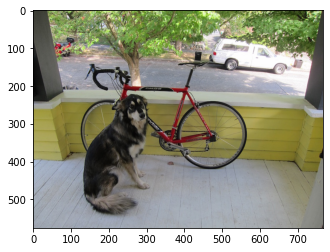

In [ ]:
main_test_image ("/content/drive/MyDrive/Social Distancing Detector/test_images/test1.jpg")

loading YOLO from disk...


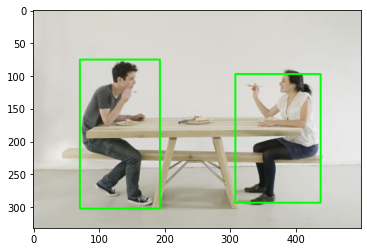

In [ ]:
main_test_image ("/content/drive/MyDrive/Social Distancing Detector/test_images/test2.jpg")

loading YOLO from disk...


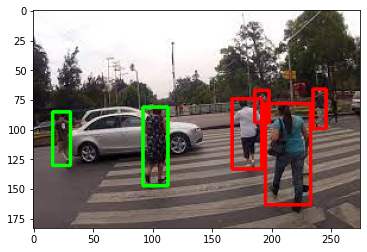

In [ ]:
main_test_image ("/content/drive/MyDrive/Social Distancing Detector/test_images/test3.jfif")

loading YOLO from disk...


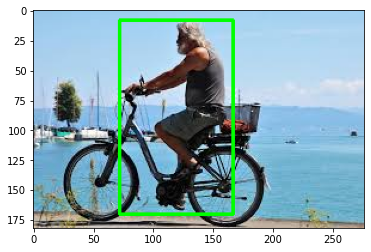

In [ ]:
main_test_image ("/content/drive/MyDrive/Social Distancing Detector/test_images/test4.jfif")

# **test on video**

In [ ]:
# initialize the video stream, pointer to output video file, and frame dimensions
input_video="/content/drive/MyDrive/Social Distancing Detector/test_video/pedestrians.mp4"
output_video="/content/drive/MyDrive/Social Distancing Detector/test_video/pedestrians_output.avi"
distance_threshold=80
cap=cv2.VideoCapture(input_video)
fps = cap.get(cv2.CAP_PROP_FPS)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
codec = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
writer = cv2.VideoWriter(output_video,codec,fps, (int(width),int (height)))
yolo_net,ln=load_yolov3(configPath,weightsPath)
while True:
	# read the next frame from the file
  (grabbed, frame) = cap.read()
  
	# if the frame was not grabbed, then we have reached the end
	# of the stream
  if not grabbed:
    break
  results,midpoints=detect_person(frame,ln,yolo_net,confidence_threshold,non_max_suppression_threshold)
  dist=compute_distance(midpoints)
  p1,p2=find_closest(dist,midpoints,distance_threshold)
  warning_red(frame,p1,p2,results)
  # write the output frame to disk
  writer.write(frame)
  print("[INFO] : WRITING OUTPUT VIDEO")

loading YOLO from disk...
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITING OUTPUT VIDEO
[INFO] : WRITI